# Řešení obyčejných diferenciálních rovnic (ODR)

V této kapitole se seznámíme s řešením obyčejných diferenciálních rovnic (ODR) na počítači. Obecný tvar ODR *N-tého* řádu je následující:

$$
p(x, y, y^{\prime}, y^{\prime \prime}, \dots, y^{(n)}) = 0, \hspace{5pt} y^{(i)}(0) = y_0^i \hspace{5pt} \forall i \in [0, N-1],
$$

kde $y^{(i)}(0) = y_0^i$ je sada $n$ počátečních podmínek pro hodnoty jednotlivých derivací funkce $y$ v počátečním bodě $0$. Vidíme, že diferenciální rovnice není sama o sobě kompletní řešitelnou úlohou. Jelikož máme vztah obsahující derivace neznámé funkce, potřebujeme vždy znát nějaké okrajové nebo počáteční podmínky. Zde jsme představili případ, kdy známe počáteční hodnotu všech derivací funkce $y$ do stupně $n-1$ v **jednom bodě**. Taková úloha se nazývá *počáteční problém*. Druhým typem úlohy (*okrajový problém*), kdy podmínky nemusí být zadané pouze v jednom bodě, se budeme zabývat v posledním cvičení. 

Předchozí diferenciální rovnici lze vždy převést na soustavu $n$ obyčejných diferenciálních rovnic prvního řádu (viz přednáška):

$$
\frac{dy_i}{dx} = f(x, y_0, y_1, \dots, y_{n-1}), \hspace{5pt} y_i(0) = y_0^i \hspace{5pt} \forall i \in [0, N-1],
$$

nebo vektorově:

$$
\frac{d \vec{y}}{dx} = f(x, \vec{y}), \hspace{5pt} \vec{y}(0) = \vec{y}_0.
$$

Obyčejné diferenciální rovnice typicky popisují vývoj určitého dynamického systému (kde $x \equiv t$ je chápáno jako čas). Příkladem může být:
* exponenciální růst (populace): 

$$
\frac{dN}{dt} = r N
$$

* logistický růst (populace): 

$$
\frac{dN}{dt} = r_{max}\frac{K - N}{K} N
$$

![Růst populace](../images/growth.png)

* harmonický oscilátor: 

$$
m \ddot{x} = -k x
$$

* Keplerova úloha: 

$$
\ddot{\vec{r}} = -\frac{G M}{r^3} \vec{r}
$$

V předchozím cvičení jsme viděli, že integrování je speciálním případem řešení ODR s $f = f(x)$ a nulovou počáteční podmínkou. Skutečně řešení ODR můžeme chápat jako postupné přičítání příspěvků změny (derivace, která je daná funcí $f(x, y)$) hodnoty funkce $y(x)$. Výhoda metod řešících ODR spočívá v možnosti volby **adaptivního kroku** (tak jak je vyžadováno) v průběhu výpočtu, jak uvidíme zanedlouho.

Základní myšledka, jak ODR řešit na počítači, spočívá v nahražení diferenciálů $dy$ a $dx$ pomocí velmi malých, ale konečných příspěvků $\Delta y$ a $\Delta x$. Tím získáme *soustavu algebraických rovnic*, které již na počítači dokázeme efektivně řešit. Také uvidíme, že určení **chyby** výpočtu je analogické jako v případě integrace. Využije řešení získané stejnou metodou při odlišném kroku.

Existují tři hlavní typy metod pro řešení ODR:
* Runge-Kuttovy metody
* Bulirsch-Stoerova metoda
* Metody prediktor-korektor

Zde se zaměříme zejména na první dvě skupiny, jelikož jednodušší verze metod typu prediktor-korektor jsou exaktně stejné jako Runge-Kuttovy metody. Přesto, jako vždy, okomentujeme výhody a nevýhody různých metod. Jako vždy v numerice neexistuje jedna nejlepší metoda na všechny možné úlohy!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Pro testování různých metod použijeme následující úlohu (obdoba *vývoje populace*):

$$
\frac{dy(t)}{dt} = (1 + 2\cos{(t)}) y(t)
$$

U této diferenciální rovnice lze určit řešení analyticky: $\tilde{y}(t) = \exp(t + 2\sin{(t)}) \tilde{y}(0)$.

In [21]:
def f(t, y):
    return (1 + 2*np.cos(t)) * y

def y_sol(t):
    return np.exp(t + 2*np.sin(t)) 

# počáteční podmínka
y_0 = 1

# časový interval
T0 = 0
T = 5

## Runge-Kuttovy metody

Hlavní myšlenkou těchto metod je vývoj řešení (funkce $y$) pomocí lineární kombinace vnořených kroků jednoduché Eulerovy metody (následující sekce). Tato lineární kombinace je srovnána s *Taylorovým rozvojem* určitého řádu.

Obecný vzorec pro *explicitní metody* pro ODR N-tého řádu:

$$
y_{i+1} = y_i + h \sum_{j = 1}^{r} b_j k_j(h), \hspace{5pt} \forall i \in [0, N-1],
$$

kde 

$$
k_j = f(x_i + c_j h, y_i + h \sum_{l = 1}^{j-1} a_{jl} k_l)
$$

Koeficienty jsou získány srovnáním s Taylorovým rozvojem požadovaného řádu. Existuje nekonečně mnoho kombinací koeficientů, kterými lze získat požadovanou aproximaci. Runge-Kuttovy metody se pak efektivně popisují *Butcherovou tabulkou*, ve které se vyskytují hodnoty všech koeficientů dané metody:

$$
\begin{array}
{c|cccc}
c_1 & a_{11} & 0 & \cdots & 0 \\
c_2 & a_{21} & a_{22} & \cdots & 0 \\
\vdots & \vdots & \vdots  & \ddots & \vdots \\
c_r & a_{r1} & a_{r2} & \cdots & a_{rr}\\
\hline
& b_1 & b_2 & \cdots & b_{r}
\end{array}
$$

Následující dvě metody odpovídají jednoduchému nahrazení derivace pomocí buď *dopředné* (Euler) nebo *centrální* diference (leap-frog). Přesto tyto metody spadají do obecné definice RK metod, a proto si je předstabujeme zde.

Dále se budeme věnovat pouze metodám pro řešení **ODR 1. řádu**. Vzorec pro RK metody je stejný, akorát $y$ je skalár.

Vlastnosti:
* velmi robustní pro nehladké funkce $f$, adaptivní krok $h$
* více výpočtů pravé strany $f$ -> nevýhodné pokud výpočetně náročné
* většinou nejrychlejší, bežně používané RK4 (RK45 - vnořená metoda)

### Eulerova metoda

Nejjednoduší možností, jak se vypořádat s derivací je nahrazení diferenciálů pomocí konečných rozdílů vzdálených konečným krokem $\Delta \equiv h$:

$$
\frac{dy}{dx} \approx \frac{y_{i+1} - y_{i}}{x_{i+1} - x_{i}} = f(x_i, y_i),
$$

kde $y_i = y(x_i)$. Tedy po úpravě dostáváme jednoduchý explicitní vzorec pro vývoj $y$:

$$
y_{n+1} = y_{n} + h f(x_n, y_n),
$$

s počáteční podmínkou $y(x_0) = y_0$. Dostáváme tedy RK metodu 1. řádu.

Zde znovu zmíníme analogii s integračními metodami. Eulerova metoda dokonce přímo odpovídá levostrannému integračnímu pravidlu!

![Eulerova metoda](../images/eulerRK.png)

Zvolíme počet kroků:

In [29]:
# pocet kroku
M = 100

# delka kroku
h = (T - T0) / M

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Implementujte *Eulerovu metodu* pro řešení zkušební ODR.
</p>
</div>
</div>

In [55]:
def euler(f, y_0, h, steps):
    y = np.zeros(steps+1)  # reseni
    y[0] = y_0
    
    t = T0
    for i in range(steps):
        ## DOPLŇTE ##
        y[i+1] = y[i] + h*f(t, y[i])
        t += h
    
    return y

y_euler = euler(f, y_0, h, steps=M)

print('y_euler:', y_euler[-1])
print('y_sol:  ', y_sol(T))

y_euler: 17.567021635626023
y_sol:   21.805264918818242


Text(0.5, 0, '$t$')

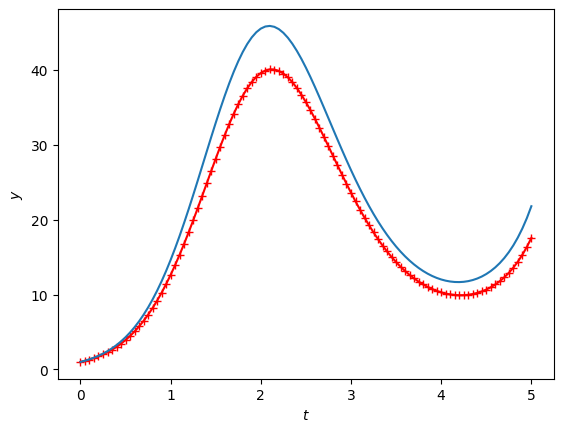

In [56]:
# casove kroky
ts = np.linspace(T0, T, M+1)

plt.plot(ts, y_euler, marker="+", color='r')
plt.plot(ts, y_sol(ts))

plt.ylabel(r'$y$')
plt.xlabel(r'$t$')

### Metoda středního bodu (midpoint/leap-frog)

Metoda středního bodu je RK metoda 2. řádu využívající kombinace dvou hodnot pravé strany (derivace):

$$
\begin{align}
    k_1 &= f(x_n, y_n) \\
    k_2 &= f(x_n + \frac{h}{2}, y_n + \frac{h}{2} k_1) \\
    y_{n+1} &= y_n + h k_2,
\end{align} 
$$

s počáteční podmínkou $y(x_0) = y_0$.

Tato metoda je ekvivalentní nahrazení derivace pomocí centrární diference:

$$
y_{n+1} = y_{n-1} + 2h f(x_n, y_n).
$$

Toto schéma se typicky nazývá *leap-frog*, jelikož využívá hodnotu funkce $y$ o dva kroky zpět v čase.

![Midpoint metoda](../images/midpointRK.png)

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Implementujte *metodu středního bodu* pro řešení zkušební ODR.
</p>
</div>
</div>

In [57]:
def midpoint(f, y_0, h, steps):
    y = np.zeros(steps+1)  # reseni
    y[0] = y_0
    
    t = T0
    for i in range(steps):
        ## DOPLŇTE ##
        k1 = f(t, y[i])
        k2 = f(t + h/2, y[i] + k1 * h/2)
        y[i+1] = y[i] + h*k2
        t += h
    
    return y

y_midpoint = midpoint(f, y_0, h, steps=M)

print('y_midpoint:', y_midpoint[-1])
print('y_sol:     ', y_sol(T))

y_midpoint: 21.657042981408324
y_sol:      21.805264918818242


Text(0.5, 0, '$t$')

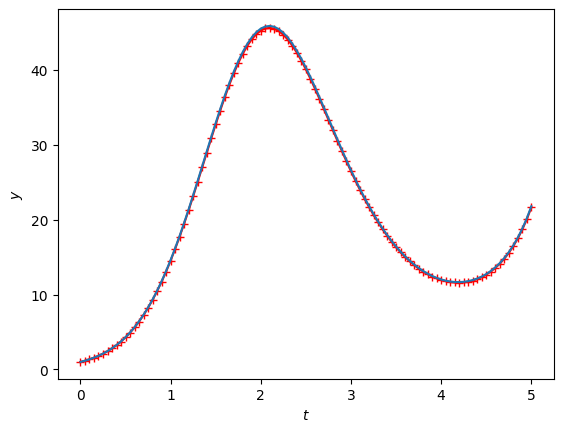

In [58]:
# casove kroky
ts = np.linspace(T0, T, M+1)

plt.plot(ts, y_midpoint, marker="+", color='r')
plt.plot(ts, y_sol(ts))

plt.ylabel(r'$y$')
plt.xlabel(r'$t$')

### Heunova metoda

Heunova metoda je opět RK metoda 2. řádu využívající tentokrát jiné kombinace dvou hodnot pravé strany (derivace):

$$
\begin{align}
    k_1 &= f(x_n, y_n) \\
    k_2 &= f(x_n + h, y_n + h k_1) \\
    y_{n+1} &= y_n + \frac{h}{2} (k_1 + k_2),
\end{align} 
$$

s počáteční podmínkou $y(x_0) = y_0$.

![Heunova metoda](../images/heuneRK.png)

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Implementujte *Heunovu metodu* pro řešení zkušební ODR.
</p>
</div>
</div>

In [92]:
def heune(f, y_0, h, steps):
    y = np.zeros(steps+1)  # reseni
    y[0] = y_0
    
    t = T0
    for i in range(steps):
        ## DOPLŇTE ##
        k1 = f(t, y[i])
        k2 = f(t + h, y[i] + k1 * h)
        y[i+1] = y[i] + h/2*(k1 + k2)
        t += h
    
    return y

y_heune = heune(f, y_0, h, steps=M)

print('y_heune:', y_heune[-1])
print('y_sol:  ', y_sol(T))

y_heune: 21.62849358238237
y_sol:   21.805264918818242


Text(0.5, 0, '$t$')

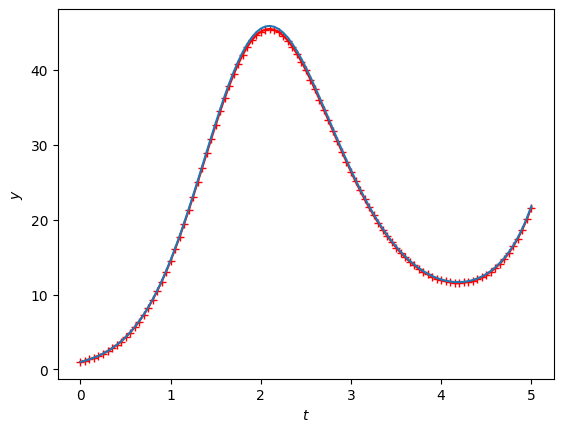

In [62]:
# casove kroky
ts = np.linspace(T0, T, M+1)

plt.plot(ts, y_heune, marker="+", color='r')
plt.plot(ts, y_sol(ts))

plt.ylabel(r'$y$')
plt.xlabel(r'$t$')

### Runge-Kuttova metoda 4. řádu

Nejpoužívanějším typem jsou RK4 metody. To je dané tím, že pro RK metody 5 a vyšších řádů je již potřeba víc vyhodnocení funkce pravé strany, než je řád metody. Proto RK4 metody představují ideální poměr cena-výkon. 
Jedna z nejpoužívanějších je následující RK4 metoda:

$$
\begin{align}
    k_1 &= f(x_n, y_n) \\
    k_2 &= f(x_n + \frac{h}{2}, y_n + \frac{h}{2} k_1) \\
    k_3 &= f(x_n + \frac{h}{2}, y_n + \frac{h}{2} k_2) \\
    k_4 &= f(x_n + h, y_n + h k_3) \\
    y_{n+1} &= y_n + \frac{h}{6} (k_1 + 2 k_2 + 2 k_3 + k_4),
\end{align} 
$$

s počáteční podmínkou $y(x_0) = y_0$.

![Heunova metoda](../images/rk4.png)

In [63]:
def rk4(f, y_0, h, steps):
    y = np.zeros(steps+1)  # reseni
    y[0] = y_0
    
    t = T0
    for i in range(steps):
        ## DOPLŇTE ##
        k1 = f(t, y[i])
        k2 = f(t + h/2, y[i] + k1 * h/2)
        k3 = f(t + h/2, y[i] + k2 * h/2)
        k4 = f(t + h, y[i] + k3 * h)
        y[i+1] = y[i] + h/6*(k1 + 2*k2 + 2*k3 + k4)
        t += h
    
    return y

y_rk4 = rk4(f, y_0, h, steps=M)

print('y_rk4: ', y_rk4[-1])
print('y_sol: ', y_sol(T))

y_rk4:  21.805099910191213
y_sol:  21.805264918818242


Text(0.5, 0, '$t$')

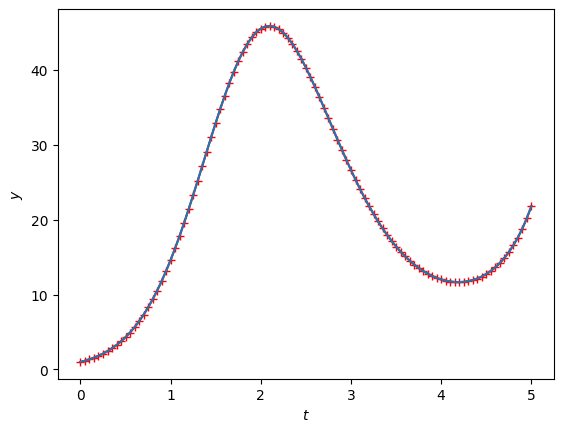

In [65]:
# casove kroky
ts = np.linspace(T0, T, M+1)

plt.plot(ts, y_rk4, marker="+", color='r')
plt.plot(ts, y_sol(ts))

plt.ylabel(r'$y$')
plt.xlabel(r'$t$')

## Bulirsch-Stoerova metody

Tato metoda je založená na stejném principu jako *Rombergova metoda* u integrace. Tedy cíl je využít výsledku dané metody pro různé kroky pro zlepšení řádu metody. U integrace jsme měli velmi vhodnou metodu založenou na *lichoběžníkovém pravidlu*, jejíž rozvoj chyby obsahoval členy pouze sudého řádu. Zde chceme využít metodu se stejnou vlastností.

![Bulirsch-Stoerova metoda](../images/bulirschStoer.png)

Jako vhodná výchozí metoda se ukáže modifikovaná midpoint metoda:

$$
\begin{align}
    y_1 &= y_0 + h f(x_0, y_0), \\
    y_{n+1} &= y_{n-1} + 2 h f(x_n, y_n), \hspace{5pt} \forall n = 1, 2, \dots, M-1 \\
    \tilde{y}_{M} &\approx \frac{1}{2} \left( y_{M} + y_{M-1} + h f(x_M, y_{M}) \right)
\end{align} 
$$

Pro modifikovanou metodu platí:

$$
\tilde{y}_M - y_M = a h^2 + b h^4 + c h^6 + \dots 
$$

Postup Bulirsch-Stoerovy je tedy následující:
* spočítat řešení $y_{M}$ s krokem $h$ a $2h$
* aproximovat řešení pomocí:

$$
\tilde{y}_M \approx \frac{4 y^{h}_M - y^{2h}_M}{3}
$$

* tím z metody 2. řádu získáme metodu *4. řádu*! 

Vlastnosti Bulirsch-Stoerovy metody:
* méně vhodné pro komplikovaný tvar funkce $f$ nebo obsahující singularity v integrovaném intervalu
* pro hladké funkce $f$ poskytuje řešení s velmi vysokou přesností s menším počtem vyhodnocení funkce $f$ oproti RK metodám stejného řádu

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Implementujte *modifikovanou metodu středního bodu* pro řešení zkušební ODR.
</p>
</div>
</div>

In [96]:
def midpoint_mod(f, y_0, h, steps):
    y = np.zeros(steps+1)  # reseni
    y[0] = y_0
    
    t = T0
    y[1] = y[0] + h * f(t, y[0])  # prvni krok Euler
    t += h
    
    for i in range(1, steps):
        y[i+1] = y[i-1] + 2*h* f(t, y[i])
        t += h
    
    y[-1] = 1/2 * (y[-1] + y[-2] + h*f(t, y[-1]))
    return y

y_midpoint_mod = midpoint_mod(f, y_0, h, steps=M)

print('y_midpoint_mod:', y_midpoint_mod[-1])
print('y_sol:         ', y_sol(T))

y_midpoint_mod: 21.6141166716386
y_sol:          21.805264918818242


Text(0.5, 0, '$t$')

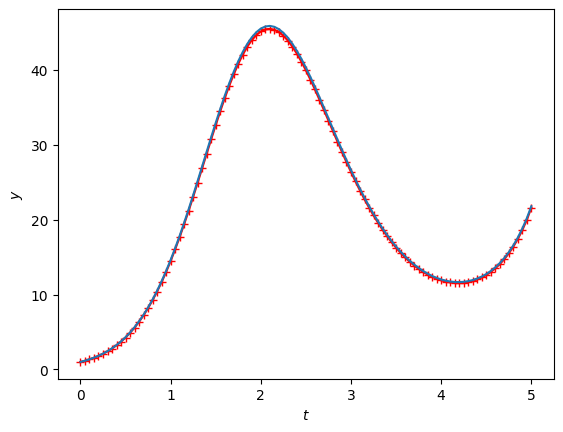

In [97]:
# casove kroky
ts = np.linspace(T0, T, M+1)

plt.plot(ts, y_midpoint_mod, marker="+", color='r')
plt.plot(ts, y_sol(ts))

plt.ylabel(r'$y$')
plt.xlabel(r'$t$')

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Implementujte *Bulirsch-Stoerovu metodu* pro řešení zkušební ODR.
</p>
</div>
</div>

In [101]:
y_midpoint_mod_h = midpoint_mod(f, y_0, h, steps=M)
y_midpoint_mod_2h = midpoint_mod(f, y_0, 2*h, steps=M//2)

y_M = (4*y_midpoint_mod_h[-1] - y_midpoint_mod_2h[-1]) / 3

print('y_bulirschStoer:', y_M)
print('y_sol:          ', y_sol(T))

y_bulirschStoer: 21.795112319685316
y_sol:           21.805264918818242


## Runge-Kuttovy metody pro soustavu ODR (nD)



<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol - zápočet 4</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

[ZDE](ukol4)
</p>
</div>
</div>